

```
# This is formatted as code
```

# Denoising Autoencoder on STL-10 Images

##  Objective
This project implements a **Denoising Autoencoder (DAE)** to restore noisy grayscale images using deep learning. The autoencoder is trained to reconstruct clean versions of images corrupted by Gaussian noise.

##  Dataset
We use the **STL-10** dataset, which contains natural images of 96x96 resolution. For this experiment:
- A subset of **100 grayscale images** is selected for training.
- **20 images** are used for testing.
- All images are resized to **64x64** and converted to **grayscale**.
  
##  Noise Injection
To simulate real-world corruption:
- We apply **Gaussian noise** to a fixed number of random pixels in each image.
- Both a **loop-based** and a **vectorized** noise function are used and compared for efficiency.

## Model: Denoising Autoencoder
A **convolutional autoencoder** is built using PyTorch. It consists of:
- An **encoder** that compresses the noisy image into a latent representation.
- A **decoder** that reconstructs the clean image from this latent space.

## Training Strategy
- **K-Fold Cross-Validation** (k=5) is used for reliable evaluation.
- We perform **Grid Search** over learning rate, batch size, and epochs to identify the best hyperparameters.
- The model is evaluated using:
  - **MSE (Mean Squared Error)**
  - **PSNR (Peak Signal-to-Noise Ratio)**

##  Performance Profiling
The PyTorch **Profiler** is used to analyze:
- Time spent on different operations (CPU/CUDA)
- Memory usage
- FLOPs and throughput in GFLOPs/sec

##  Visualization
Finally, reconstructed images are plotted alongside their noisy inputs and ground truths to visually assess denoising quality.

---


In [1]:
!pip install skorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 20.3 MB/s eta 0:00:00


In [2]:
#Importing Necessary Libraries
from torchvision.datasets import STL10
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import STL10
from torchvision import transforms
import torch.optim as optim
import random
from torch.utils.data import random_split
import time
from torch.profiler import profile, record_function, ProfilerActivity
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetRegressor

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
# Define the transform pipeline
transform = transforms.Compose([
    transforms.Grayscale(),        # Convert to grayscale
    transforms.Resize((64, 64)),   # Resize to 64x64
    transforms.ToTensor()
])

# Load the train dataset
train_data = STL10(root='./data', split='train',transform=transform,download=True)

# Load the test dataset
test_data = STL10(root='./data', split='test',transform=transform,download=True)
# Generate 100 unique random indices from the training set
random.seed(42)
random_indices = random.sample(range(len(train_data)), 100)
images = torch.stack([train_data[i][0] for i in random_indices])

# Similarly, select 20 random test images
random.seed(42)
test_random_indices = random.sample(range(len(test_data)), 20)
test_images = torch.stack([test_data[i][0] for i in test_random_indices])

In [8]:
def insert_noise_vectorized(images_tensor, number_of_corrupted_pixels, noise_scale):
    """
    Vectorized version of the insert_noise function.

    Args:
        images_tensor (torch.Tensor): Tensor of shape (N, 1, H, W)
        number_of_corrupted_pixels (int): Number of pixels to corrupt per image.
        noise_scale (float): Scale of the Gaussian noise.

    Returns:
        torch.Tensor: Noisy images of shape (N, 1, H, W)
    """
    N, C, H, W = images_tensor.shape
    noised_images = images_tensor.clone()

    total_pixels = H * W
    for i in range(N):
        indices = torch.randperm(total_pixels)[:number_of_corrupted_pixels]
        rows = indices // W
        cols = indices % W
        noise = torch.randn(number_of_corrupted_pixels) * noise_scale
        noised_images[i, 0, rows, cols] += noise

    noised_images = torch.clamp(noised_images, 0.0, 1.0)
    return noised_images


'''
The following is another method for inserting noise . The time taken using this function was greater than the above used as the above is vectorized .
'''
def insert_noise(images_list,number_of_corrupted_pixels,noise_scale):
  noised_images = []
  H, W = 64, 64          # image dimensions

  for image in images_list:
      # each image: shape (1, 64, 64)
    noisy_image = image.clone() # copy to avoid modifying original

      # Generate 20 unique (row, col) coordinates
    indices = random.sample(range(H * W), number_of_corrupted_pixels)
    for idx in indices:

      row = idx // W
      col = idx % W
      # Add Gaussian noise at this pixel only
      noisy_image[0, row, col] += torch.randn(1).item() * noise_scale  # adjust noise scale
    noisy_image = torch.clamp(noisy_image, 0.0, 1.0)
    noised_images.append(noisy_image)
  return noised_images


In [9]:
#Applying inset_noise funtion to train and test images for input into the model. Time taken was more than that taken by the vectorized function
start_time = time.time()
noised_images=insert_noise(images,400,4)
test_noised_images=insert_noise(test_images,400,4)
end_time = time.time()
print(f"Dataset noise insertion without vectorization completed in {end_time - start_time:.3f} seconds")
#Applying inset_noise funtion to train and test images for input into the model
start_time = time.time()
noised_images=insert_noise_vectorized(images,400,4)
test_noised_images=insert_noise_vectorized(test_images,400,4)

end_time = time.time()
print(f"Dataset noise insertion with vectorization completed in {end_time - start_time:.3f} seconds")

Dataset noise insertion without vectorization completed in 1.638 seconds
Dataset noise insertion with vectorization completed in 0.035 seconds


In [10]:
#Defining out Denoising Autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()

        # ---------- Encoder ----------
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=2, stride=1, padding=1),   # → (16, 65, 65)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=1),  # → (32, 66, 66)
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # → (64, 8, 8)
            nn.ReLU()
        )

        # ---------- Decoder ----------
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (32, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=1, padding=1),  # → (16, 67, 67)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=1, padding=2),   # → (1, 64, 64) after tuning
            nn.Sigmoid()  # Normalize output to [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:

#Function to calculate PSNR (Peak Signal to Noise Ratio)
def calculate_psnr(output, target, max_pixel_value=1.0):
    mse = F.mse_loss(output, target, reduction='mean')
    if mse == 0:
        return float('inf')
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr.item()

In [12]:
# Wrap your model in a callable function
def create_autoencoder():
    return DenoisingAutoencoder()

# Define the skorch wrapper
net = NeuralNetRegressor(
    module=create_autoencoder,  # use a function or lambda for dynamic creation
    optimizer=torch.optim.Adam,
    criterion=nn.MSELoss,
    max_epochs=10,
    lr=1e-3,
    batch_size=10,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

In [14]:
def train_model(
    model_class,
    full_input_tensor, full_output_tensor,
    test_input_tensor, test_output_tensor,
    k_folds=5,

    criterion=nn.MSELoss(),
    optimizer_fn=lambda params: optim.Adam(params, lr=1e-3),
    epochs=20,
    batch_size=10,
    device='cpu',
    use_profiler=True,
    verbose=True
):
    fold_size = full_input_tensor.size(0) // k_folds
    indices = torch.randperm(full_input_tensor.size(0))

    # Per-epoch metrics for averaging
    train_losses = [[] for _ in range(epochs)]
    val_losses = [[] for _ in range(epochs)]
    test_losses = [[] for _ in range(epochs)]

    train_psnrs = [[] for _ in range(epochs)]
    val_psnrs = [[] for _ in range(epochs)]
    test_psnrs = [[] for _ in range(epochs)]
    test_inputs = test_input_tensor.to(device)
    test_targets = test_output_tensor.to(device)
    for fold in range(k_folds):
        val_idx = indices[fold * fold_size:(fold + 1) * fold_size]
        train_idx = torch.cat((indices[:fold * fold_size], indices[(fold + 1) * fold_size:]), dim=0)

        train_inputs = full_input_tensor[train_idx].to(device)
        train_targets = full_output_tensor[train_idx].to(device)
        val_inputs = full_input_tensor[val_idx].to(device)
        val_targets = full_output_tensor[val_idx].to(device)
        model = model_class().to(device)
        optimizer = optimizer_fn(model.parameters())

        if use_profiler and fold == 0:
            prof = profile(
                activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
                record_shapes=True,
                profile_memory=True,
                with_stack=True,
                with_flops=True
            )
            prof.__enter__()
        else:
            prof = None

        for epoch in range(epochs):
            #Training
            model.train()
            permutation = torch.randperm(train_inputs.size(0))
            epoch_loss, epoch_psnr = 0.0, 0.0

            for i in range(0, train_inputs.size(0), batch_size):
                idx = permutation[i:i + batch_size]
                inputs = train_inputs[idx]
                targets = train_targets[idx]

                with record_function("forward_backward"):
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                epoch_loss += loss.item() * inputs.size(0)
                epoch_psnr += calculate_psnr(outputs, targets) * inputs.size(0)

            avg_train_loss = epoch_loss / train_inputs.size(0)
            avg_train_psnr = epoch_psnr / train_inputs.size(0)
            train_losses[epoch].append(avg_train_loss)
            train_psnrs[epoch].append(avg_train_psnr)

            # Validation
            model.eval()
            with torch.no_grad():
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_targets).item()
                val_psnr = calculate_psnr(val_outputs, val_targets)
                val_losses[epoch].append(val_loss)
                val_psnrs[epoch].append(val_psnr)

                test_outputs = model(test_inputs)
                test_loss = criterion(test_outputs, test_targets).item()
                test_psnr = calculate_psnr(test_outputs, test_targets)
                test_losses[epoch].append(test_loss)
                test_psnrs[epoch].append(test_psnr)

            if prof and epoch == 0:
                prof.step()
                prof.__exit__(None, None, None)
                print("\n[Profiler output —]")
                print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

                key_averages = prof.key_averages()
                total_flops = 0.0
                total_time_us = 0.0

                for evt in key_averages:
                    if evt.flops > 0:
                        total_flops += evt.flops
                        total_time_us += evt.self_cpu_time_total  # in microseconds

                if total_time_us > 0:
                    gflops_per_sec = (total_flops / 1e9) / (total_time_us / 1e6)
                    print(f"FLOP-based Throughput: {gflops_per_sec:.2f} GFLOPs/sec")
                else:
                    print("Could not compute FLOP throughput (time too small or missing)")
                use_profiler = False
        if verbose:
            print(f"[Fold {fold+1}/{k_folds}] Final Val Loss: {val_losses[-1][-1]:.4f}, PSNR: {val_psnrs[-1][-1]:.2f}")

    # Average over folds
    def avg(lst_of_lists):
        return [sum(values)/len(values) for values in lst_of_lists]

    return {
        'train_loss': avg(train_losses),
        'train_psnr': avg(train_psnrs),
        'val_loss': avg(val_losses),
        'val_psnr': avg(val_psnrs),
        'test_loss': avg(test_losses),
        'test_psnr': avg(test_psnrs),
        'model': model
    }



In [16]:
def grid_search(
    model_class,
    full_input_tensor, full_output_tensor,
    test_input_tensor, test_output_tensor,
    learning_rates,
    batch_sizes,
    epochs_list,
    k_folds=5,
    device='cpu',
    enable_profiler=False  # pass to train_model
):
    best_val_loss = float('inf')
    best_params = None
    best_results = None
    best_model = None

    for lr in learning_rates:
        for batch_size in batch_sizes:
            for epochs in epochs_list:
                print(f"\nTraining with lr={lr}, batch_size={batch_size}, epochs={epochs}...")


                results = train_model(
                    model_class=model_class,
                    full_input_tensor=full_input_tensor,
                    full_output_tensor=full_output_tensor,
                    test_input_tensor=test_input_tensor,
                    test_output_tensor=test_output_tensor,
                    optimizer_fn=lambda params: optim.Adam(params, lr=lr),
                    batch_size=batch_size,
                    epochs=epochs,
                    device=device,
                    k_folds=k_folds,
                    use_profiler=enable_profiler,  # pass flag down
                    verbose=False
                )

                current_val_loss = results['val_loss'][-1]
                print(f" Final Validation Loss (Avg. over folds): {current_val_loss:.4f}")

                if current_val_loss < best_val_loss:
                    best_val_loss = current_val_loss
                    best_params = {'lr': lr, 'batch_size': batch_size, 'epochs': epochs}
                    best_results = results
                    best_model = results['model']

    print(f"\n Best Hyperparameters: {best_params}")
    print(f" Best Validation Loss: {best_val_loss:.4f}")

    return best_params, best_results, best_model

In [17]:
learning_rates = [1e-2,1e-3,1e-4]
batch_sizes = [5,10]
epochs_list = [20,40,60]

best_params, best_results ,best_model= grid_search(
    DenoisingAutoencoder,
    noised_images, images,
    test_noised_images, test_images,
    learning_rates,
    batch_sizes,
    epochs_list,
    enable_profiler=True,
    device=device,
    k_folds = 5
)


Training with lr=0.01, batch_size=5, epochs=20...

[Profiler output —]
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls   Total FLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       forward_backward         0.00%       0.000us         0.00%       0.000us       0.00

In [18]:
#Function to Plot the Input, Recostructed image from Autoencoder and Ground truth

def plot_image(input_image,output_image) :
  best_model.eval()  # Set model to evaluation mode
  with torch.no_grad():  # Disable gradient tracking
      input_image = input_image.unsqueeze(0).to(device)
      reconstructed_image = best_model(input_image)
    # Convert to 2D for grayscale display
  original = input_image.squeeze().cpu().numpy()
  reconstructed = reconstructed_image.squeeze().cpu().numpy()
  expected_output=output_image.squeeze().cpu().numpy()

  # Plot
  plt.figure(figsize=(10, 6))
  plt.subplot(1, 3, 1)
  plt.imshow(original, cmap='gray')
  plt.title("Noisy Input")
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.imshow(reconstructed, cmap='gray')
  plt.title("Reconstructed ")
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.imshow(expected_output, cmap='gray')
  plt.title("Ground Truth ")
  plt.axis('off')

  plt.show()

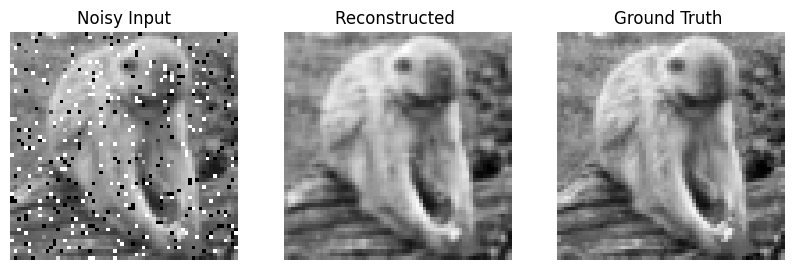

In [19]:

#Showcasing an image from train dataset that has been reconstructed by the autoencoder
input1=noised_images[1]
output1=images[1]
plot_image(input1,output1)

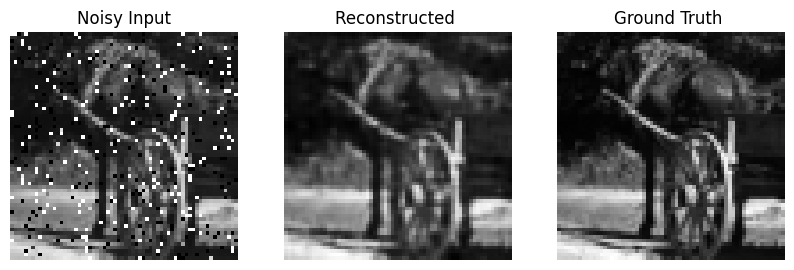

In [20]:
#Showcasing an image from train dataset that has been reconstructed by the autoencoder
input1=test_noised_images[10]
output1=test_images[10]
plot_image(input1,output1)